# Running TARDIS with a custom packet source

In [1]:
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.montecarlo.packet_source import BasePacketSource
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/traitlets/traitlets.py:3036: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,
 (warnings.py:110)


In [2]:
download_atom_data('kurucz_cd23_chianti_H_He')

[tardis.io.atom_data.atom_web_download][INFO   ]  Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (atom_web_download.py:46)


Custom packet source class that is derived from BasePacketSource. The method create_packets (which returns ```radii, nus, mus, energies```) has to be defined.

In [3]:
class TruncBlackbodySource(BasePacketSource):
    """
        Custom inner boundary source class to replace the Blackbody source
        with a truncated Blackbody source.
    """
    
    def __init__(self, seed, truncation_wavelength):
        super().__init__(seed)
        self.rng = np.random.default_rng(seed=seed)
        self.truncation_wavelength = truncation_wavelength
    
    def create_packets(self, T, no_of_packets, rng, radius,
                       drawing_sample_size=None):
        """
        Packet source that generates a truncated Blackbody source.
        
        Parameters
        ----------
        T : float
            Blackbody temperature
        no_of_packets : int
            number of packets to be created
        truncation_wavelength : float
            truncation wavelength in Angstrom. 
            Only wavelengths higher than the truncation wavelength
            will be sampled.
        """
        
        # Makes uniform array of packet radii
        radii = np.ones(no_of_packets) * radius

        # Use mus and energies from normal blackbody source.
        mus = self.create_zero_limb_darkening_packet_mus(no_of_packets, self.rng)
        energies = self.create_uniform_packet_energies(no_of_packets, self.rng)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = u.Quantity(self.truncation_wavelength, u.Angstrom).to(
                                          u.Hz, equivalencies=u.spectral()).value
        
        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_blackbody_packet_nus(T, drawing_sample_size, self.rng)
        nus = nus[nus<truncation_frequency][:no_of_packets]
        
        
        # Only required if the truncation wavelength is too big compared to the maximum 
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_blackbody_packet_nus(
                T, drawing_sample_size, self.rng
            )
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]
            
        return radii, nus, mus, energies

In [4]:
packet_source = TruncBlackbodySource(
    53253, truncation_wavelength=2000
)

In [5]:
mdl = run_tardis('tardis_example.yml',
                 packet_source=packet_source)
mdl_norm = run_tardis('tardis_example.yml')

[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:91)


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:34)


[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:179)


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:183)


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.03511e+42 erg / s Luminosity absorbed = 2.57323e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9926.501965  9413.138423  0.400392  0.675086
	5      9852.611678  9735.709498  0.211205  0.240419
	10     9779.813302  9621.763697  0.142695  0.144937
	15     9708.082813  9348.762000  0.104556  0.109191

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 10669.940 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05983e+43 erg / s Luminosity absorbed = 3.51337e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9413.138423  9614.904143  0.675086  0.834076
	5      9735.709498  9889.358606  0.240419  0.301399
	10     9621.763697  9822.410963  0.144937  0.178229
	15     9348.762000  9611.481991  0.109191  0.129098

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10669.940 K -- next t_inner 10668.540 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06660e+43 erg / s Luminosity absorbed = 3.44468e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 1/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9614.904143  9663.537874  0.834076  0.813546
	5      9889.358606  9868.171357  0.301399  0.302669
	10     9822.410963  9805.715870  0.178229  0.180267
	15     9611.481991  9630.016813  0.129098  0.128926

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10668.540 K -- next t_inner 10650.196 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05846e+43 erg / s Luminosity absorbed = 3.42744e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 2/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9663.537874  9635.030695  0.813546  0.820131
	5      9868.171357  9929.187039  0.302669  0.294506
	10     9805.715870  9793.094239  0.180267  0.178893
	15     9630.016813  9597.348788  0.128926  0.129975

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10650.196 K -- next t_inner 10652.237 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05638e+43 erg / s Luminosity absorbed = 3.45768e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 3/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9635.030695  9673.834170  0.820131  0.802905
	5      9929.187039  9954.933169  0.294506  0.292823
	10     9793.094239  9847.096482  0.178893  0.175051
	15     9597.348788  9662.154378  0.129975  0.126106

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10652.237 K -- next t_inner 10659.533 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06333e+43 erg / s Luminosity absorbed = 3.42625e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 4/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9673.834170  9683.416914  0.802905  0.803980
	5      9954.933169  9926.290941  0.292823  0.298802
	10     9847.096482  9850.011631  0.175051  0.176968
	15     9662.154378  9611.820614  0.126106  0.129828

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10659.533 K -- next t_inner 10649.371 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05814e+43 erg / s Luminosity absorbed = 3.42961e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 5/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9683.416914  9652.112530  0.803980  0.804732
	5      9926.290941  9940.533580  0.298802  0.292523
	10     9850.011631  9850.733041  0.176968  0.174921
	15     9611.820614  9636.469777  0.129828  0.127349

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10649.371 K -- next t_inner 10652.232 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05628e+43 erg / s Luminosity absorbed = 3.46071e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 6/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9652.112530  9683.051465  0.804732  0.804751
	5      9940.533580  9975.499261  0.292523  0.288370
	10     9850.733041  9916.269986  0.174921  0.170496
	15     9636.469777  9678.878674  0.127349  0.124775

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10652.232 K -- next t_inner 10659.778 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05855e+43 erg / s Luminosity absorbed = 3.47902e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 7/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9683.051465   9705.923927  0.804751  0.792978
	5      9975.499261  10058.607472  0.288370  0.278739
	10     9916.269986   9906.627126  0.170496  0.170254
	15     9678.878674   9742.711391  0.124775  0.122118

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10659.778 K -- next t_inner 10661.601 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06427e+43 erg / s Luminosity absorbed = 3.43214e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 8/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9705.923927  9701.469433  0.792978  0.800020
	5      10058.607472  9951.361263  0.278739  0.292612
	10      9906.627126  9882.214022  0.170254  0.173647
	15      9742.711391  9671.510102  0.122118  0.126587

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10661.601 K -- next t_inner 10649.082 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05961e+43 erg / s Luminosity absorbed = 3.41179e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 9/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9701.469433  9678.571946  0.800020  0.802607
	5      9951.361263  9899.536376  0.292612  0.297034
	10     9882.214022  9882.948355  0.173647  0.174445
	15     9671.510102  9672.655511  0.126587  0.125752

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10649.082 K -- next t_inner 10648.250 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05702e+43 erg / s Luminosity absorbed = 3.43305e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 10/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9678.571946  9654.180514  0.802607  0.814406
	5      9899.536376  9949.369589  0.297034  0.292542
	10     9882.948355  9933.192681  0.174445  0.169005
	15     9672.655511  9694.372371  0.125752  0.124521

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10648.250 K -- next t_inner 10653.924 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05949e+43 erg / s Luminosity absorbed = 3.43768e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 11/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9654.180514  9664.006353  0.814406  0.809247
	5      9949.369589  9941.182147  0.292542  0.292125
	10     9933.192681  9842.794054  0.169005  0.175525
	15     9694.372371  9640.852034  0.124521  0.128115

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10653.924 K -- next t_inner 10653.390 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05969e+43 erg / s Luminosity absorbed = 3.43196e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 12/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9664.006353  9644.299727  0.809247  0.816073
	5      9941.182147  9944.872343  0.292125  0.293828
	10     9842.794054  9845.192468  0.175525  0.175077
	15     9640.852034  9648.942261  0.128115  0.127103

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10653.390 K -- next t_inner 10652.339 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05673e+43 erg / s Luminosity absorbed = 3.45391e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 13/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9644.299727  9609.873461  0.816073  0.823182
	5      9944.872343  9920.654106  0.293828  0.298745
	10     9845.192468  9933.632291  0.175077  0.170755
	15     9648.942261  9670.506999  0.127103  0.126140

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10652.339 K -- next t_inner 10658.756 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06568e+43 erg / s Luminosity absorbed = 3.40382e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 14/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9609.873461  9641.080018  0.823182  0.814588
	5      9920.654106  9965.965853  0.298745  0.289063
	10     9933.632291  9846.717343  0.170755  0.177210
	15     9670.506999  9623.977565  0.126140  0.129022

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10658.756 K -- next t_inner 10642.724 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05494e+43 erg / s Luminosity absorbed = 3.42557e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9641.080018  9666.722016  0.814588  0.803579
	5      9965.965853  9997.950585  0.289063  0.284080
	10     9846.717343  9936.664371  0.177210  0.168476
	15     9623.977565  9723.021420  0.129022  0.122793

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10642.724 K -- next t_inner 10653.645 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05877e+43 erg / s Luminosity absorbed = 3.44420e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 1/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9666.722016  9646.951396  0.803579  0.811830
	5      9997.950585  9958.799446  0.284080  0.291721
	10     9936.664371  9807.487863  0.168476  0.177634
	15     9723.021420  9633.753514  0.122793  0.127732

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10653.645 K -- next t_inner 10654.911 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05814e+43 erg / s Luminosity absorbed = 3.45497e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 2/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9646.951396  9654.117057  0.811830  0.811528
	5      9958.799446  9895.751055  0.291721  0.299514
	10     9807.487863  9870.543880  0.177634  0.173738
	15     9633.753514  9649.763076  0.127732  0.126960

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10654.911 K -- next t_inner 10657.771 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05991e+43 erg / s Luminosity absorbed = 3.45298e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 35.06 s (base.py:381)


[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:91)


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:34)


[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:179)


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:183)


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:323)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 7.94275e+42 erg / s Luminosity absorbed = 2.65805e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9926.501965  10134.733717  0.400392  0.508204
	5      9852.611678  10222.890845  0.211205  0.197026
	10     9779.813302  10144.463169  0.142695  0.117179
	15     9708.082813   9873.477846  0.104556  0.086941

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 10703.004 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06938e+43 erg / s Luminosity absorbed = 3.59205e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10134.733717  10823.353779  0.508204  0.523698
	5      10222.890845  10966.119397  0.197026  0.201292
	10     10144.463169  10767.494140  0.117179  0.125481
	15      9873.477846  10454.887282  0.086941  0.093925

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10703.004 K -- next t_inner 10677.675 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.07223e+43 erg / s Luminosity absorbed = 3.43160e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10823.353779  11003.007879  0.523698  0.484095
	5      10966.119397  11217.406253  0.201292  0.187047
	10     10767.494140  10986.662247  0.125481  0.116657
	15     10454.887282  10602.989741  0.093925  0.088797

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10677.675 K -- next t_inner 10645.320 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06171e+43 erg / s Luminosity absorbed = 3.36905e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 1/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11003.007879  11024.833085  0.484095  0.471469
	5      11217.406253  11281.172357  0.187047  0.180027
	10     10986.662247  11006.086811  0.116657  0.114520
	15     10602.989741  10658.538101  0.088797  0.086118

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10645.320 K -- next t_inner 10639.210 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05662e+43 erg / s Luminosity absorbed = 3.38360e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 2/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11024.833085  10983.398664  0.471469  0.481378
	5      11281.172357  11246.046239  0.180027  0.180961
	10     11006.086811  10994.443181  0.114520  0.114832
	15     10658.538101  10680.606204  0.086118  0.085315

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10639.210 K -- next t_inner 10645.891 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05953e+43 erg / s Luminosity absorbed = 3.39055e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 3/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10983.398664  11016.280985  0.481378  0.474748
	5      11246.046239  11258.366946  0.180961  0.182113
	10     10994.443181  11028.206080  0.114832  0.113366
	15     10680.606204  10674.899150  0.085315  0.085351

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10645.891 K -- next t_inner 10645.253 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06093e+43 erg / s Luminosity absorbed = 3.37742e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 4/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11016.280985  11018.902656  0.474748  0.471642
	5      11258.366946  11331.945678  0.182113  0.175502
	10     11028.206080  11049.550703  0.113366  0.112259
	15     10674.899150  10640.993233  0.085351  0.086356

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10645.253 K -- next t_inner 10641.099 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05931e+43 erg / s Luminosity absorbed = 3.36893e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 5/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11018.902656  11085.843853  0.471642  0.465883
	5      11331.945678  11340.645531  0.175502  0.175714
	10     11049.550703  11121.078792  0.112259  0.109834
	15     10640.993233  10706.990578  0.086356  0.084040

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10641.099 K -- next t_inner 10641.025 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05487e+43 erg / s Luminosity absorbed = 3.40939e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 6/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11085.843853  11090.504299  0.465883  0.464073
	5      11340.645531  11384.800685  0.175714  0.173931
	10     11121.078792  11066.750641  0.109834  0.112216
	15     10706.990578  10696.184641  0.084040  0.084325

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10641.025 K -- next t_inner 10652.130 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06918e+43 erg / s Luminosity absorbed = 3.32992e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 7/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11090.504299  11044.552184  0.464073  0.470780
	5      11384.800685  11265.716644  0.173931  0.183286
	10     11066.750641  11037.455408  0.112216  0.114267
	15     10696.184641  10647.258067  0.084325  0.087186

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10652.130 K -- next t_inner 10627.404 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05469e+43 erg / s Luminosity absorbed = 3.34337e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 8/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11044.552184  11026.265756  0.470780  0.472036
	5      11265.716644  11167.711116  0.183286  0.186082
	10     11037.455408  10990.477658  0.114267  0.114653
	15     10647.258067  10688.585363  0.087186  0.084614

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10627.404 K -- next t_inner 10638.944 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05352e+43 erg / s Luminosity absorbed = 3.41399e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 9/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11026.265756  11093.934930  0.472036  0.464086
	5      11167.711116  11327.664990  0.186082  0.176947
	10     10990.477658  11065.454924  0.114653  0.111779
	15     10688.585363  10664.224287  0.084614  0.085157

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10638.944 K -- next t_inner 10653.449 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06124e+43 erg / s Luminosity absorbed = 3.41125e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 10/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11093.934930  11087.616381  0.464086  0.465963
	5      11327.664990  11330.559989  0.176947  0.177567
	10     11065.454924  11039.745961  0.111779  0.113007
	15     10664.224287  10707.928541  0.085157  0.085246

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10653.449 K -- next t_inner 10648.521 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06268e+43 erg / s Luminosity absorbed = 3.37461e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 11/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11087.616381  11097.427029  0.465963  0.465081
	5      11330.559989  11300.646957  0.177567  0.180849
	10     11039.745961  11077.994925  0.113007  0.111683
	15     10707.928541  10692.187941  0.085246  0.084873

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10648.521 K -- next t_inner 10639.984 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05328e+43 erg / s Luminosity absorbed = 3.41810e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 12/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11097.427029  10980.286687  0.465081  0.481102
	5      11300.646957  11289.725566  0.180849  0.179719
	10     11077.994925  11112.158142  0.111683  0.109970
	15     10692.187941  10760.236873  0.084873  0.082817

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10639.984 K -- next t_inner 10655.113 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05828e+43 erg / s Luminosity absorbed = 3.45208e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 13/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10980.286687  11052.016105  0.481102  0.471620
	5      11289.725566  11328.967648  0.179719  0.175136
	10     11112.158142  11059.164698  0.109970  0.112497
	15     10760.236873  10676.944741  0.082817  0.084821

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10655.113 K -- next t_inner 10657.616 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.06690e+43 erg / s Luminosity absorbed = 3.38194e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 14/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11052.016105  11105.713345  0.471620  0.461479
	5      11328.967648  11385.314994  0.175136  0.174755
	10     11059.164698  11150.956904  0.112497  0.109009
	15     10676.944741  10746.029309  0.084821  0.083550

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10657.616 K -- next t_inner 10638.555 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05949e+43 erg / s Luminosity absorbed = 3.35404e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 15/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11105.713345  11090.287538  0.461479  0.459918
	5      11385.314994  11334.366140  0.174755  0.176420
	10     11150.956904  11072.762142  0.109009  0.111931
	15     10746.029309  10665.033185  0.083550  0.085020

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10638.555 K -- next t_inner 10638.020 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05375e+43 erg / s Luminosity absorbed = 3.40609e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Iteration converged 16/4 consecutive times. (base.py:227)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11090.287538  11068.061151  0.459918  0.465076
	5      11334.366140  11343.432862  0.176420  0.175066
	10     11072.762142  11123.779036  0.111931  0.109327
	15     10665.033185  10640.418102  0.085020  0.085494

 (base.py:433)


[tardis.simulation.base][INFO   ]  t_inner 10638.020 K -- next t_inner 10651.961 K (base.py:434)


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:323)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.05925e+43 erg / s Luminosity absorbed = 3.42288e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:438)


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 21.29 s (base.py:381)


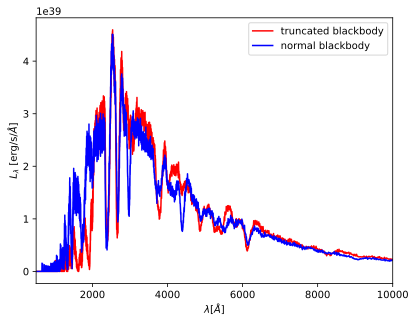

In [6]:
%matplotlib inline
plt.plot(mdl.runner.spectrum_virtual.wavelength,
         mdl.runner.spectrum_virtual.luminosity_density_lambda,
         color='red', label='truncated blackbody')
plt.plot(mdl_norm.runner.spectrum_virtual.wavelength,
         mdl_norm.runner.spectrum_virtual.luminosity_density_lambda,
         color='blue', label='normal blackbody')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()